In [1]:
from mrcnn import model as modellib, utils
from mrcnn.config import Config
import os
import warnings

warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\jatin\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
class BuildingConfig(Config):
    """Configuration for training on data in MS COCO format.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "OSM_buildingdetector"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you get "ResourceExhaustedError" while running training
    IMAGES_PER_GPU = 2

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # 1 Backgroun + 1 Building

    STEPS_PER_EPOCH=1000
    VALIDATION_STEPS=50


    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320

In [11]:
MODEL_DIR = ''
ROOT_DIR = ''

In [58]:
class InferenceConfig(BuildingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "weights/pretrained_weights.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  weights/pretrained_weights.h5


In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [6]:
im = Image.open('osm_images/tmp.PNG')
im = im.resize((320,320), Image.ANTIALIAS)

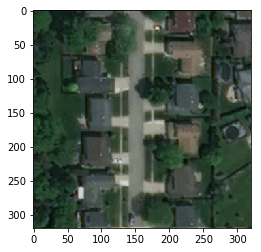

In [7]:
plt.imshow(np.array(im)[:,:,:3])

In [8]:
import imageio

In [9]:
def plot_mask(masks, labels):
    if masks is None: # just an empty plot
        plt.imshow(np.zeros([512,512,3]).astype(np.uint8))
        return
    net_image = np.zeros([masks.shape[0],masks.shape[1],3])
    assert masks.shape[-1] == len(labels)
    for i in range(masks.shape[2]):
        m = masks[:,:,i].astype(np.uint8)[:,:,None]
        mask = np.append(m,m,axis=2)
        mask = np.append(mask,m,axis=2)
        if labels[i] == 'building':
            mask = mask * np.array([25,160,90]) # yellow for corn
        net_image += mask
    plt.imshow(net_image.astype(np.uint8))

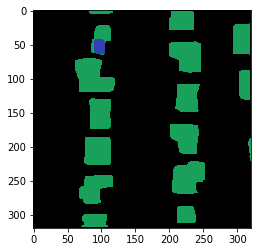

In [10]:
im = Image.open('osm_images/tmp.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])]) # it works!!

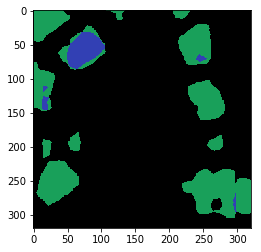

In [11]:
im = Image.open('osm_images/tmp4.PNG')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])])

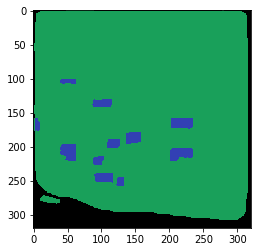

In [28]:
im = Image.open('click_original.png')
im = im.resize((320,320), Image.ANTIALIAS)
out = model.detect([imageio.core.util.Array(np.array(im)[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])])

In [16]:
out[0]['masks'][0,0,0].any()

False

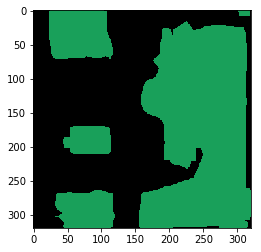

In [24]:
plot_mask(out[0]['masks'].any(axis=2)[:,:,None], ['building'])

In [32]:
plt.imsave('tmp',out[0]['masks'].any(axis=2)) # easy way to condense

In [33]:
for i, image in enumerate(['a', 'b', 'c']):
    print(i, image)

0 a
1 b
2 c


In [89]:
image = np.array(Image.open('click_original.png'))

In [90]:
image_tl = image[:len(image)//2, :len(image)//2,:] # top left
image_tr = image[len(image)//2:, :len(image)//2,:] # top right
image_br = image[len(image)//2:, len(image)//2:,:] # bottom right
image_bl = image[:len(image)//2, len(image)//2:,:] # bottom left

mask_tl = None
mask_tr = None
mask_br = None
mask_bl = None
for i, image in enumerate([image_tl, image_tr, image_br, image_bl]):
    image = Image.fromarray(image)
    original_size = (image.size[0], image.size[1])
    image = image.resize((320,320), Image.ANTIALIAS)
    detection = model.detect([imageio.core.util.Array(np.array(image)[:,:,:3])])
    masks = detection[0]['masks']
    masks = masks.any(axis=2) # doesn't solve overlap problem
    masks = Image.fromarray(masks).resize(original_size, Image.ANTIALIAS)
    if i == 0: mask_tl = masks
    elif i == 1: mask_tr = masks
    elif i == 2: mask_br = masks
    else: mask_bl = masks

mask_up = np.hstack((mask_tl, mask_tr))
mask_down = np.hstack((mask_bl, mask_br))

In [91]:
masks = np.vstack((mask_up, mask_down))

In [92]:
masks.shape

(768, 768)

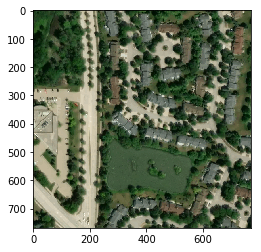

In [93]:
plt.imshow(np.array(Image.open('click_original.png')))

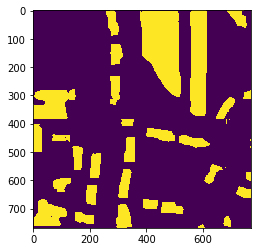

In [94]:
plt.imshow(masks)

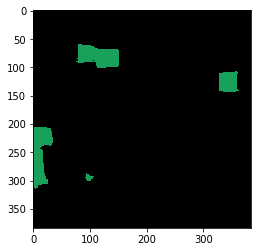

In [64]:
out = model.detect([imageio.core.util.Array(image_tl[:,:,:3])])
plot_mask(out[0]['masks'], ['building' for _ in range(out[0]['masks'].shape[-1])])

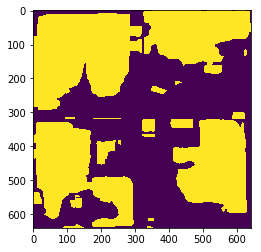

In [44]:
plt.imshow(masks)

In [34]:
??print